# CEWA 568 Snow Hydrology - Spring 2023
## Lab 2-2: Kettle Ponds snow pillow, precipitation, and temperature data (East River Valley)

Written by Eli Schwat (elilouis@uw.edu) - March 2023

Modified December 2024.

---

This lab will introduce you to data from the Sublimation of Snow (SoS) field campaign. The SoS field site is at Kettle Ponds within the East River valley near Crested Butte, CO. 

## Library imports

In [7]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Open SoS Data

In [8]:
# You may need to install this library:
!pip install netcdf4

In [9]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

## Open precipitation dataset
Note we immediately convert the csv (opened with pandas as a dataframe) to an xarray dataset so that we have the same format for both datsets

In [5]:
precip_file = "../data/kettle_ponds_precip.csv"
precip_dataset = pd.read_csv(precip_file)
precip_dataset['date'] = pd.to_datetime(precip_dataset['date'])
precip_dataset = precip_dataset.set_index('date').to_xarray()

precip_dataset

<xarray.Dataset> Size: 17kB
Dimensions:     (date: 269)
Coordinates:
  * date        (date) datetime64[ns] 2kB 2022-10-01 2022-10-02 ... 2023-06-26
Data variables:
    Unnamed: 0  (date) int64 2kB 0 1 2 3 4 5 6 7 ... 170 171 172 173 174 175 176
    doy         (date) float64 2kB 274.0 275.0 276.0 277.0 ... 175.0 176.0 177.0
    acc_prec    (date) float64 2kB 0.96 10.22 10.38 10.38 ... 763.1 763.1 763.2
    avg         (date) float64 2kB 0.96 9.26 0.16 0.0 0.0 ... 0.0 0.0 0.0 0.07
    geo1        (date) float64 2kB 0.72 9.4 0.21 0.0 0.0 ... 0.0 0.0 0.0 0.21
    geo2        (date) float64 2kB 1.06 9.0 0.26 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    geo3        (date) float64 2kB 1.08 9.4 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Plot
We use the Matplotlib library because integrates nicely with Xarray and makes creating simple plots quickly an easy task.

Before plotting, we resample the SoS dataset by finding the daily mean. We don't need the 30 minute data to look at season long changes. Also, the snow pillow dataset has lots of nans so resampling makes the plot look better. The precipitaton dataset is already daily, so we don't need to resample it.

In [6]:
sos_dataset_daily = sos_dataset.resample(time="1440Min").mean()

Now we plot the data. Note that SWE_p1_c, SWE_p2_c, SWE_p3_c, SWE_p24_ corresponse to the snow pillows beneath towers UW, UE, C, D, respectively.

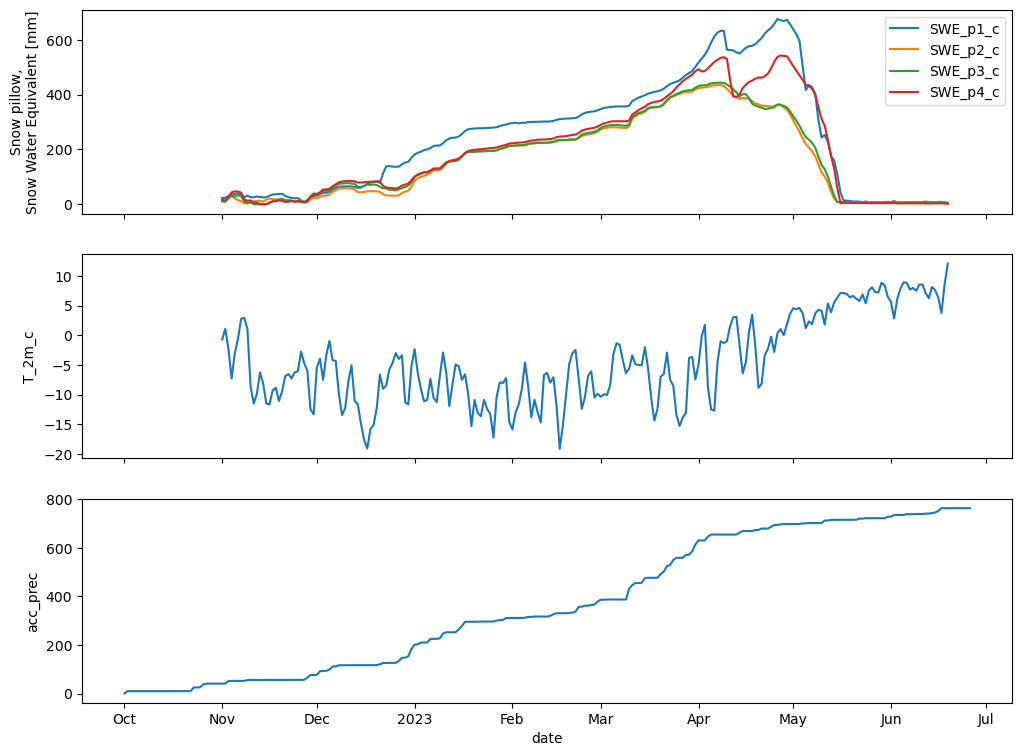

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12,9), sharex=True)
sos_dataset_daily['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_daily['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_daily['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_daily['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')
sos_dataset_daily['T_2m_c'].plot(ax=axes[1])
precip_dataset['acc_prec'].plot(ax=axes[2])
axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
# axes[0].set_xlim(dt.datetime(2022,11,1), dt.datetime(2023,3,27))
plt.show()